In [1]:
import numpy as np
import pyopencl as cl
from PIL import Image
from IPython.display import display, clear_output

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch import Tensor
from torch.autograd import Variable
import torchvision.transforms as T

In [4]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 8.0)
plt.rcParams['image.interpolation'] = 'bilinear'
plt.rcParams['image.cmap'] = 'hot'

In [5]:
from clutil import *
from compute import *

%load_ext autoreload
%autoreload 2

In [6]:
def convert_depth(depth_buffer, max_depth):
    return (255*np.log(np.maximum(depth_buffer, 0) + 1)/np.log(max_depth + 1)).astype(np.uint8)

def convert_color(color_buffer):
    return (255*np.clip(color_buffer, 0, 1)).astype(np.uint8)

In [7]:
def plot_images(data):
    if len(data.shape) == 3:
        plt.imshow(convert_color(data))
        plt.axis('off')
    elif len(data.shape) == 4:
        for i, img in enumerate(data):
            plt.subplot(1, len(data), i+1)
            plt.imshow(convert_color(img))
            plt.axis('off')
    elif len(data.shape) == 5:
        for j, seq in enumerate(data):
            for i, img in enumerate(seq):
                plt.subplot(len(seq), len(data), i*len(data)+j+1)
                plt.imshow(convert_color(img))
                plt.axis('off')
    plt.show()

In [8]:
ctx = cl.create_some_context()

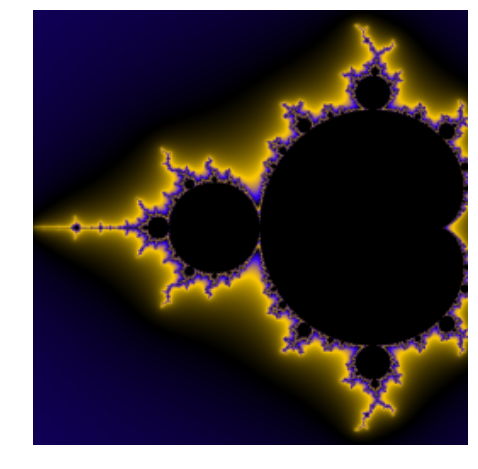

In [9]:
scene = Scene(ctx, (256, 256), scale=4)
scene.compute((-0.8, 0), (2.4, 0), max_depth=1024)
plot_images(scene.colorize([[0,0,0,1], [1,0.8,0,1], [0.2,0,1,1]], period=20))

In [10]:
def discover(
    branches,
    jump=4,
    scene=None,
    pos=np.array([[-0.8, 0]]),
    zoom=2.4,
    md=1024,
    temp=(0.2, 0.05),
):
    if len(branches) <= 0:
        return np.concatenate((pos, np.full((pos.shape[0],1),zoom)), axis=-1)
    
    if scene is None:
        scene = Scene(ctx, (240, 210), scale=1)
    
    ps = [np.concatenate((pos, np.full((pos.shape[0],1),zoom)), axis=-1)]
    for p in pos:
        fp = search(scene, pos=p, zoom=(zoom,0), max_depth=md, temp=temp, n=branches[0])
        ps.append(discover(branches[1:], jump=jump, scene=scene, pos=fp, zoom=zoom/jump, md=md, temp=temp))
    return np.concatenate(ps)

In [11]:
discover([4, 2, 1], jump=4)#, draw=scene)

array([[-0.8       ,  0.        ,  2.4       ],
       [-1.61142857, -0.06857143,  0.6       ],
       [-0.20571429,  1.04      ,  0.6       ],
       [-0.67428571,  0.56      ,  0.6       ],
       [-0.84571429, -0.49142857,  0.6       ],
       [-1.34571429,  0.10285714,  0.15      ],
       [-1.32      ,  0.13428571,  0.15      ],
       [-1.32857143,  0.08      ,  0.0375    ],
       [-1.24214286,  0.17357143,  0.0375    ],
       [-0.12857143,  0.97428571,  0.15      ],
       [-0.18571429,  1.11142857,  0.15      ],
       [-0.11428571,  0.92142857,  0.0375    ],
       [-0.16357143,  1.06214286,  0.0375    ],
       [-0.47428571,  0.66571429,  0.15      ],
       [-0.79142857,  0.31142857,  0.15      ],
       [-0.47285714,  0.62642857,  0.0375    ],
       [-0.71857143,  0.265     ,  0.0375    ],
       [-0.74857143, -0.19428571,  0.15      ],
       [-0.8       , -0.24857143,  0.15      ],
       [-0.77428571, -0.13571429,  0.0375    ],
       [-0.72714286, -0.25285714,  0.037

In [12]:
def generate(scene, branches, jump):
    images = []
    for pos in discover(branches, jump=jump):
        scene.compute(pos[0:2], (pos[2],0), max_depth=1024)
        images.append(scene.colorize([[0,0,0,1], [1,0.8,0,1], [0.2,0,1,1]], period=20))
    return np.stack(images)

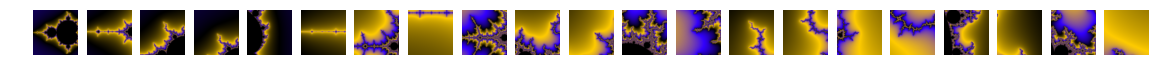

In [13]:
plot_images(generate(scene, [4, 2, 1], 4))

In [14]:
torch.cuda.is_available()

True

In [15]:
class UNetLike(nn.Module):
    def __init__(self, down, middle, up, ksize=3):
        super().__init__()
        
        self.kernel_size = ksize
        pad = (ksize - 1)//2;
        
        levels = []
        for level in down:
            layers = []
            for conv_in, conv_out in zip(level[:-1], level[1:]):
                layers.extend([
                    nn.Conv2d(conv_in, conv_out, kernel_size=ksize, padding=pad),
                    nn.ReLU(),
                ])
            layers.append(nn.MaxPool2d(2, stride=2))
            levels.append(nn.ModuleList(layers))
        self.down = nn.ModuleList(levels)
        
        layers = []
        for conv_in, conv_out in zip(middle[:-1], middle[1:]):
            layers.extend([
                nn.Conv2d(conv_in, conv_out, kernel_size=ksize, padding=pad),
                nn.ReLU(),
            ])
        self.middle = nn.ModuleList(layers)
        last_size = middle[-1]
        
        levels = []
        for level in up:
            layers = []
            layers.append(nn.ConvTranspose2d(last_size, level[0], kernel_size=2, stride=2))
            for conv_in, conv_out in zip(level[:-1], level[1:]):
                layers.extend([
                    nn.ConvTranspose2d(conv_in, conv_out, kernel_size=ksize, padding=pad),
                    nn.ReLU(),
                ])
            layers.pop()
            levels.append(nn.ModuleList(layers))
            last_size = level[-1]
        self.up = nn.ModuleList(levels)
    
    def forward(self, x):
        for d in self.down:
            for l in d:
                x = l(x)
            
        for l in self.middle:
            x = l(x)
        
        for u in self.up:
            for l in u:
                x = l(x)
        return x

In [16]:
def train_model(model, loss_fn, optimizer, data, test=False):
    if test:
        model.eval()
    else:
        model.train()
    
    x_var = Variable(Tensor(data).cuda(), volatile=test)

    if not test:
        optimizer.zero_grad()

    y_var = Variable(Tensor(data).cuda(), volatile=test)

    y_pred = model(x_var)

    loss = loss_fn(y_pred, y_var)

    if not test:
        loss.backward()#retain_graph=True)

    x_var = y_pred

    if not test:
        optimizer.step()
        
    return loss.data[0]

In [23]:
def apply_model(model, image):
    model.eval()
    x_var = Variable(Tensor(x).cuda(), volatile=True)
    y_pred = model(x_var)
    return y_pred.data.cpu().numpy()

In [31]:
model = UNetLike(
    down=(
        (3, 16, 16),
        (16, 32, 32),
        (32, 64, 64),
    ),
    middle=(64, 128, 128),
    up=(
        (64, 64, 64),
        (32, 32, 32),
        (16, 16, 16, 3),
    ),
).cuda()

In [32]:
loss_fn = nn.MSELoss().cuda()
optimizer = optim.Adam(model.parameters(), lr=2e-4)

In [39]:
train_scene = Scene(ctx, (64, 64), scale=4)
for i in range(10000):
    data = generate(scene, [2, 2, 2], 4).transpose(0,3,1,2)[:,:3,:,:]
    if i % 10 == 0:
        print("%s: %s" % (i, train_model(model, loss_fn, optimizer, data)))

0: 0.020435083657503128
10: 0.022229352965950966
20: 0.025703731924295425
30: 0.020487366244196892
40: 0.025314388796687126
50: 0.024264097213745117
60: 0.024965746328234673
70: 0.021477825939655304
80: 0.024758320301771164
90: 0.023460960015654564
100: 0.023697631433606148
110: 0.025254715234041214
120: 0.023793840780854225
130: 0.023598777130246162
140: 0.016672631725668907
150: 0.02310410514473915
160: 0.015363847836852074
170: 0.02287951484322548
180: 0.023951618000864983
190: 0.020668718963861465
200: 0.02190060168504715
210: 0.021434864029288292
220: 0.02436705119907856
230: 0.018765516579151154
240: 0.0229670237749815
250: 0.024223102256655693
260: 0.020027264952659607
270: 0.01958564668893814
280: 0.018974682316184044
290: 0.02049805410206318
300: 0.02130742371082306
310: 0.02375200390815735
320: 0.020812319591641426
330: 0.02240465022623539
340: 0.015737270936369896
350: 0.02021520398557186
360: 0.02079017087817192
370: 0.020560331642627716
380: 0.018882496282458305
390: 0.018

3120: 0.012594643980264664
3130: 0.012173730880022049
3140: 0.013043777085840702
3150: 0.012205303646624088
3160: 0.012601240538060665
3170: 0.01295162457972765
3180: 0.011107794009149075
3190: 0.011208443902432919
3200: 0.011020177975296974
3210: 0.013093976303935051
3220: 0.013980240561068058
3230: 0.01056603156030178
3240: 0.013398597948253155
3250: 0.007247042842209339
3260: 0.008470074273645878
3270: 0.009360356256365776
3280: 0.009016888216137886
3290: 0.010575332678854465
3300: 0.011831789277493954
3310: 0.011619201861321926
3320: 0.008470176719129086
3330: 0.01080399751663208
3340: 0.013813333585858345
3350: 0.0058799139223992825
3360: 0.010006914846599102
3370: 0.012300578877329826
3380: 0.013098515570163727
3390: 0.013271518982946873
3400: 0.010280085727572441
3410: 0.010295472107827663
3420: 0.010112087242305279
3430: 0.01166027132421732
3440: 0.012656810693442822
3450: 0.012709282338619232
3460: 0.012774069793522358
3470: 0.01275856327265501
3480: 0.011749450117349625
3490:

6180: 0.010691593401134014
6190: 0.011446208693087101
6200: 0.007201923057436943
6210: 0.009122028946876526
6220: 0.01026957668364048
6230: 0.011027644388377666
6240: 0.011319446377456188
6250: 0.011194922961294651
6260: 0.007638655602931976
6270: 0.01264022197574377
6280: 0.007451303768903017
6290: 0.01036667451262474
6300: 0.010202051140367985
6310: 0.011561946012079716
6320: 0.009527062997221947
6330: 0.010236500762403011
6340: 0.011729388497769833
6350: 0.010583862662315369
6360: 0.010778509080410004
6370: 0.009545612148940563
6380: 0.01212975475937128
6390: 0.01314454060047865
6400: 0.011264707893133163
6410: 0.013085749000310898
6420: 0.011091669090092182
6430: 0.010445332154631615
6440: 0.01082801166921854
6450: 0.011371400207281113
6460: 0.010722202248871326
6470: 0.011728828772902489
6480: 0.006097797770053148
6490: 0.011067763902246952
6500: 0.010225305333733559
6510: 0.00999278761446476
6520: 0.010998809710144997
6530: 0.010844217613339424
6540: 0.011109785176813602
6550: 0.

9230: 0.00838855654001236
9240: 0.01031677145510912
9250: 0.008637456223368645
9260: 0.010708856396377087
9270: 0.007559739053249359
9280: 0.009054507128894329
9290: 0.007743192836642265
9300: 0.00898665189743042
9310: 0.009163107722997665
9320: 0.011031430214643478
9330: 0.006519722752273083
9340: 0.0097547871991992
9350: 0.007956602610647678
9360: 0.008031406439840794
9370: 0.011853411793708801
9380: 0.009690847247838974
9390: 0.0098173962906003
9400: 0.009245079010725021
9410: 0.007688404526561499
9420: 0.008256189525127411
9430: 0.006706146523356438
9440: 0.009118848480284214
9450: 0.010196787305176258
9460: 0.01084776408970356
9470: 0.008381931111216545
9480: 0.007982667535543442
9490: 0.010188798420131207
9500: 0.010769485495984554
9510: 0.007220190018415451
9520: 0.009484450332820415
9530: 0.009432108141481876
9540: 0.008422567509114742
9550: 0.007818825542926788
9560: 0.006505222991108894
9570: 0.009724474512040615
9580: 0.006869475822895765
9590: 0.00982175674289465
9600: 0.01

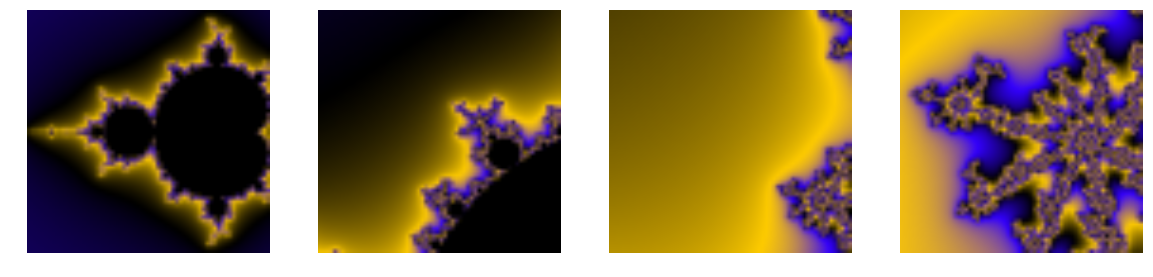

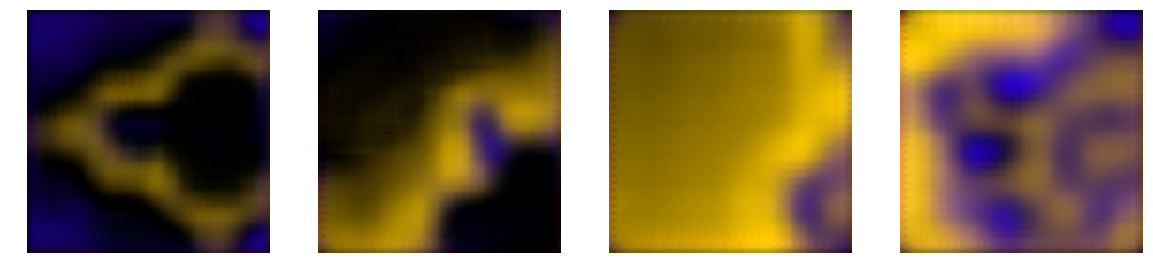

In [40]:
image = generate(train_scene, [1, 1, 1], 4)
plot_images(image)
x = image.transpose(0,3,1,2)[:,:3,:,:]
y = apply_model(model, x)
result = y.transpose(0,2,3,1)
plot_images(result)